#### Abstract
The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories.

We are going to use the supervised method XGBoost in order to predict the channel the customers come from.

#### Load Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import cv

#### Import Dataset

In [2]:
data = pd.read_csv('Wholesale_customers_data.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


Attribute Information:

1. FRESH: annual spending (m.u.) on fresh products (Continuous)
2. MILK: annual spending (m.u.) on milk products (Continuous)
3. GROCERY: annual spending (m.u.)on grocery products (Continuous)
4. FROZEN: annual spending (m.u.)on frozen products (Continuous)
5. DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
6. DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous)
7. CHANNEL: customers Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal)
8. REGION: customers Region Lisbon, Pporto or Other (Nominal)

#### Summary Statistics

In [3]:
data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [4]:
# Check for null values
data.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [5]:
# Check the types of the data
data.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [6]:
# Check the shape of the dataframe
data.shape

(440, 8)

###### Analysis
From the description above, it is clear that, all columns apart from columns Channel and Region have a high variation. 

#### Feature vector and Target vector

In [7]:
X = data.drop('Channel', axis = 1)
y = data.Channel

In [8]:
# Check the shape of two vectors
print(X.shape)
print(y.shape)

(440, 7)
(440,)


In [9]:
# Check the values of the target variable
y.unique()

array([2, 1], dtype=int64)

In [10]:
# Convert y vector to 0,1, where 0: Horeca and 1: Retail
y[y == 1] = 0
y[y == 2] = 1

In [11]:
y.value_counts()

0    298
1    142
Name: Channel, dtype: int64

In [12]:
# Convert the dataset into an optimized data structure, which supports and 
# delivers high performance and efficiency gains
data_matrix = xgb.DMatrix(X,y)

#### Split the data into train and test set

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0,
                                                   test_size = .3)

In [14]:
print(X_train.shape)
print(X_test.shape)

(308, 7)
(132, 7)


#### Train the XGBoost Model

In [15]:
# fit model in training data
clas = xgb.XGBRFClassifier(objective ='binary:logistic', 
                             learning_rate = .1, max_depth = 5, alpha = 10, 
                             n_estimators = 100)
clas.fit(X_train, y_train)

%time clas.fit(X_train, y_train)

Wall time: 116 ms


XGBRFClassifier(alpha=10, base_score=0.5, booster=None, colsample_bylevel=1,
                colsample_bynode=0.8, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints=None,
                learning_rate=0.1, max_delta_step=0, max_depth=5,
                min_child_weight=1, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=0, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=10,
                reg_lambda=1e-05, scale_pos_weight=1, subsample=0.8,
                tree_method=None, validate_parameters=False, verbosity=None)

#### Prediction

In [16]:
# Predict the model
y_pred = clas.predict(X_test)

In [17]:
pd.DataFrame(y_pred, index = X_test.index, columns = ['Prediction']).head()

,Prediction
208,1
349,1
249,0
319,1
54,0


#### Evaluation

In [18]:
confusion_matrix(y_test, y_pred)

array([[80,  6],
       [ 7, 39]], dtype=int64)

In [19]:
print('Accurancy: {:.2f}%'.format(accuracy_score(y_test, y_pred)*100))

Accurancy: 90.15%


#### k-fold Cross Validation

In [20]:
# k-fold cross validation where all the entries in the original training dataset 
# are used for both training as well as validation. each entry is used for 
# validation just once.

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_matrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True, seed=100)

In [21]:
# print the results
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.474732,0.000664,0.476380,0.000574
1,0.450236,0.003024,0.453689,0.003248
2,0.434851,0.011155,0.439088,0.010370
3,0.422072,0.004933,0.427647,0.004260
4,0.409106,0.003377,0.416045,0.003474


In [22]:
#this is the  final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1)) 

49    0.282026
Name: test-rmse-mean, dtype: float64


#### Feature Importance

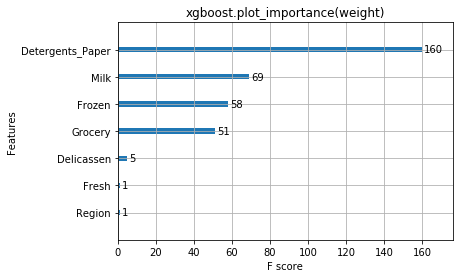

In [23]:
xgb.plot_importance(clas)
plt.title("xgboost.plot_importance(weight)")
plt.show()

The Detergents Paper category has the highest importance among all the features


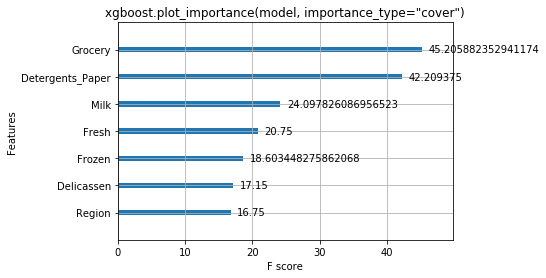

In [24]:
xgb.plot_importance(clas, importance_type="cover")
plt.title('xgboost.plot_importance(model, importance_type="cover")')
plt.show()

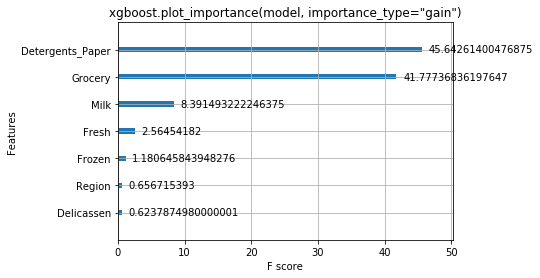

In [25]:
xgb.plot_importance(clas, importance_type="gain")
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()